# **Graph Convolutional Network (GCN)**
Es un tipo de modelo de aprendizaje automático diseñado para trabajar con datos estructurados en forma de grafos. A diferencia de las redes neuronales convencionales que trabajan con datos tabulares o imágenes, las GCN permiten el procesamiento de información en grafos, lo que las hace especialmente útiles en aplicaciones donde las relaciones y conexiones entre los elementos son importantes.

En un grafo, los elementos se representan como nodos (también conocidos como vértices) y las relaciones entre ellos se representan como aristas (también conocidas como edges). Esto podría aplicarse a diversas situaciones del mundo real, como redes sociales, sistemas de recomendación, análisis de proteínas o mapeo de rutas.

El objetivo principal de una GCN es aprender representaciones de nodos que capturen tanto la información local del nodo como la información global del grafo. Esto se logra propagando y combinando información a través de las aristas del grafo. Es decir, cada nodo se actualiza teniendo en cuenta no solo sus características propias, sino también las características de los nodos vecinos.

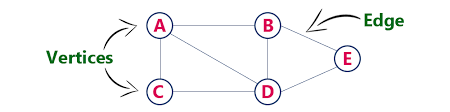

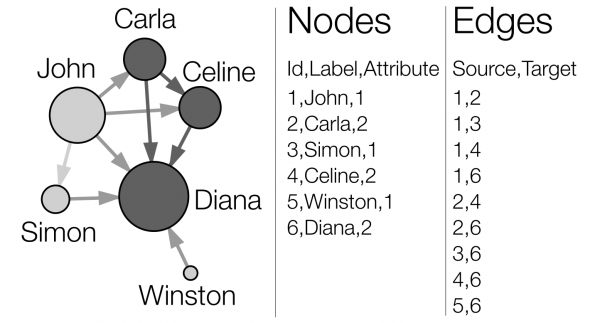

In [ ]:
  # Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.1.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Introducción a Graph Neural Networks

El aprendizaje profundo con gráfos se ha convertido en uno de los campos de investigación más populares en la comunidad del aprendizaje profundo.
Aquí, **Graph Neural Networks (GNN)** tiene como objetivo generalizar los conceptos clásicos de aprendizaje profundo a datos estructurados irregulares (en contraste con imágenes o textos) y permitir que las redes neuronales razonen sobre los objetos y sus relaciones.

Este notebook de google Colab le presentará algunos conceptos fundamentales sobre el aprendizaje profundo en grafos a través de Graph Neural Networks basadas en la **[biblioteca PyTorch Geométrica (PyG)](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geométrico es una biblioteca de extensión del popular marco de aprendizaje profundo [PyTorch](https://pytorch.org/) y consta de varios métodos y utilidades para facilitar la implementación de Graph Neural Networks.

Trabajaremos observando un ejemplo simple estructurado en grafos llamado [**red de clubes de karate de Zachary**]( https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Este gráfico describe una red social de 34 miembros de un club de karate y documenta vínculos entre miembros que interactuaron fuera del club. Aquí nos interesa detectar comunidades que surgen de la interacción del miembro.

PyTorch Geometric proporciona un fácil acceso a este conjunto de datos a través del subpaquete [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets):

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


Después de inicializar el conjunto de datos [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub), primero podemos inspeccionar algunas de sus propiedades.
Por ejemplo, podemos ver que este conjunto de datos contiene exactamente **un grafo** y que a cada nodo en este conjunto de datos se le asigna un **vector de características de 34 dimensiones** (que describe de forma única a los miembros del club de karate).
Además, el gráfico contiene exactamente **4 clases**, que representan la comunidad a la que pertenece cada nodo.

Veamos ahora el gráfico subyacente con más detalle:

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Cada grafo en PyTorch Geométrico está representado por un único objeto [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data), que contiene todos los información para describir su representación gráfica.
Podemos imprimir el objeto de datos en cualquier momento mediante `print(data)` para recibir un breve resumen sobre sus atributos y sus formas:

In [ ]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


Podemos ver que este objeto "datos" tiene 4 atributos:
(1) La propiedad `edge_index` contiene la información sobre la **conectividad del grafo**, *es decir*, una tupla de índices de nodo de origen y destino para cada borde.
Además podemos ver otras (2) **características de los nodos** como `x` (a cada uno de los 34 nodos se le asigna un vector de características de 34 dimensiones), y a (3) **etiquetas de los nodos** como `y` (cada uno de los nodos está asignado exactamente a una clase).
(4) También existe un atributo adicional llamado `train_mask`, que describe para qué nodos ya conocemos sus asignaciones de comunidad.
En total, solo conocemos las etiquetas de verdad sobre el terreno de 4 nodos (uno para cada comunidad), y la tarea es inferir la asignación de comunidad para los nodos restantes.

El objeto "datos" también proporciona algunas **funciones de utilidad** para inferir algunas propiedades básicas del grafo.
Por ejemplo, podemos inferir fácilmente si existen nodos aislados en el gráfico (*es decir* no existe ningún borde para ningún nodo), si el gráfico contiene bucles automáticos, o si el gráfico no está dirigido.

Inspeccionemos ahora la propiedad `edge_index` con más detalle:

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

Al imprimir `edge_index`, podemos comprender cómo Pytorch Geometric representa la conectividad de gráficos internamente.
Podemos ver que para cada borde, `edge_index` contiene una tupla de dos índices de nodos, donde el primer valor describe el índice de nodo del nodo de origen y el segundo valor describe el índice de nodo del nodo de destino de un borde. En otras palabras cada fila representa una arista en el grafo, donde el primer elemento de la fila es el nodo de origen y el segundo elemento es el nodo de destino de la arista.

Podemos visualizar aún más el grafo convirtiéndolo al formato de la biblioteca `networkx`:

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


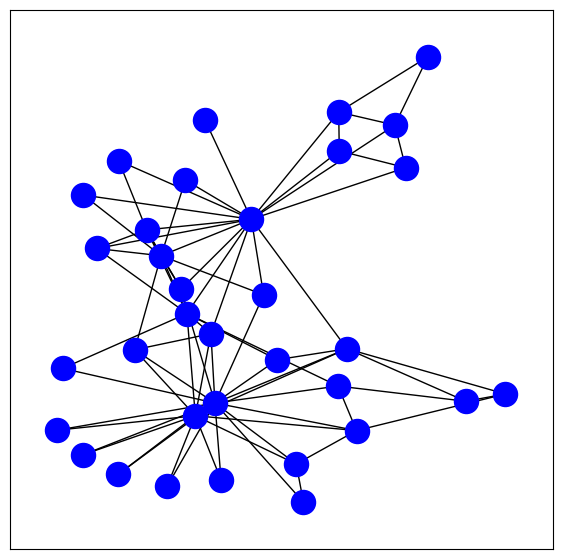

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color="blue")

Podemos usar alguna característica de la red para aplicar diferencias de colores y hacer más interpletrables los grafos

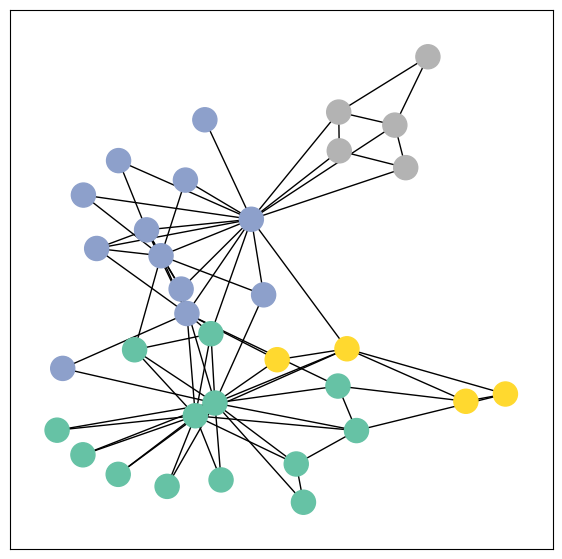

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## **Implementando una Graph Neural Networks**

PyTorch Geometric implementa una capa llamada GCNConv que se encuentra en el módulo torch_geometric.nn.conv. Esta capa se utiliza para realizar la convolución en grafos utilizando el algoritmo de Graph Convolutional Networks (GCN).

La convolución GCNConv se puede utilizar pasando dos argumentos principales: la representación de características del nodo x y la representación de conectividad del grafo edge_index. La representación de características x es un tensor que contiene las características de los nodos del grafo, mientras que edge_index es un tensor que define las conexiones entre los nodos del grafo.

Con esto, estamos listos para crear nuestra primera red neuronal Graph definiendo nuestra arquitectura de red en una clase `torch.nn.Module`:

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Aquí, primero inicializamos todos nuestros bloques de construcción en `__init__` y definimos el flujo de cálculo de nuestra red en `forward`.
Primero definimos y apilamos **tres capas de convolución de gráficos**, lo que corresponde a agregar información de vecindad de 3 saltos alrededor de cada nodo (todos los nodos a hasta 3 "saltos" de distancia).

Además, las capas `GCNConv` reducen la dimensionalidad de la característica del nodo a $2$, *es decir*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Cada capa `GCNConv` está mejorada por una no linealidad [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh).


### Embedding the Karate Club Network

Aquí, pasamos las características del nodo inicial `x` y la información de conectividad del gráfico `edge_index` al modelo, y visualizamos su distribución bidimensional. En otras palabras, el modelo GCNConv toma estas entradas y realiza un proceso llamado convolución en el grafo para generar una representación bidimensional de los nodos. Esta representación bidimensional muestra cómo los miembros del club se agrupan en función de sus características y sus interacciones en la red.

Embedding shape: [34, 2]


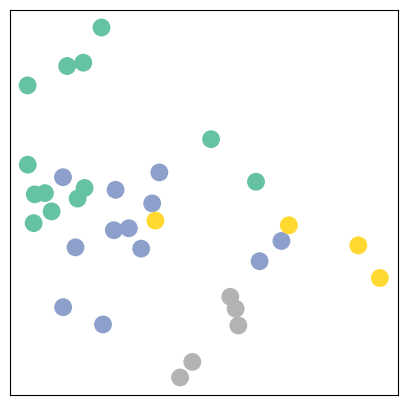

In [ ]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Sorprendentemente, incluso antes de entrenar los pesos de nuestro modelo, el modelo produce un agrupamiento de nodos que se parece mucho a la estructura de comunidades del grafo.
Los nodos del mismo color (comunidad) ya están muy agrupados en el espacio de bidimencional, aunque los pesos de nuestro modelo se inicializan **completamente al azar** .
Esto lleva a la conclusión de que los GNN introducen un fuerte sesgo inductivo, lo que lleva a agrupaciones similares para nodos que están cerca entre sí en el grafo de entrada.


### Entrenando la red de Karate Club

Veamos un ejemplo de cómo entrenar los parámetros de nuestra red en función del conocimiento de las asignaciones de comunidad de 4 nodos en el gráfico (uno para cada comunidad):

Dado que todo en nuestro modelo es diferenciable y parametrizado, podemos agregar algunas etiquetas, entrenar el modelo y observar cómo reaccionan las agrupaciones.
Aquí, utilizamos un procedimiento de aprendizaje transductivo o semisupervisado: simplemente entrenamos contra un nodo por clase, pero se nos permite utilizar los datos completos del grafo de entrada.

Entrenar nuestro modelo es muy similar a cualquier otro modelo de PyTorch.
Además de definir nuestra arquitectura de red, definimos un criterio de pérdida (aquí, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) e inicializamos un gradiente estocástico optimizador (aquí, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
Después de eso, realizamos múltiples rondas de optimización.

Vamos a utilizar o tener en cuenta en nuestro aprendizaje lo siguiente (aprendizaje semisupervisado)
```
loss = criterion(fuera[data.train_mask], data.y[data.train_mask])
```
Si bien calculamos las incorporaciones de nodos para todos nuestros nodos, **solo utilizamos los nodos de entrenamiento (nodos que conociamos a que clase pertenecen)para calcular la pérdida**.
Aquí, esto se implementa filtrando la salida del clasificador `out` y las etiquetas de verdad fundamental `data.y` para contener solo los nodos en `train_mask`.


<IPython.core.display.Javascript object>

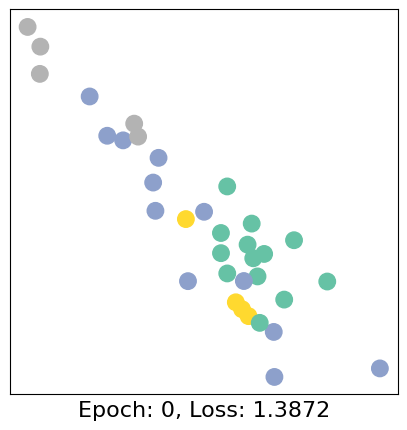

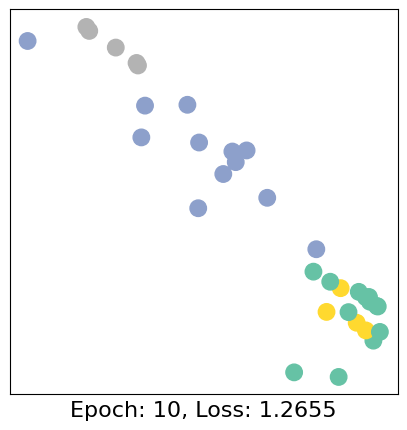

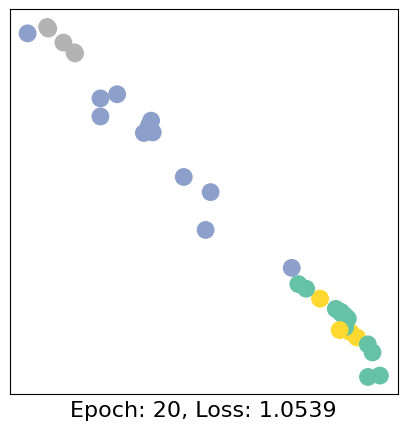

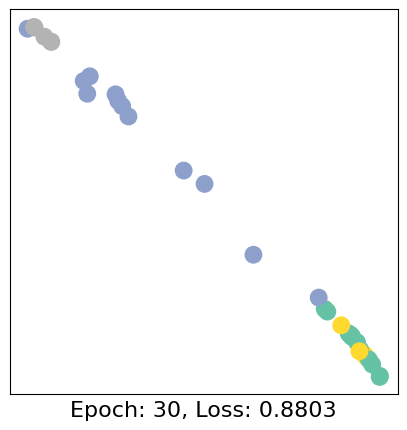

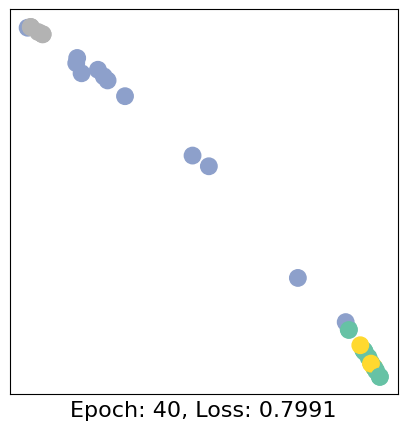

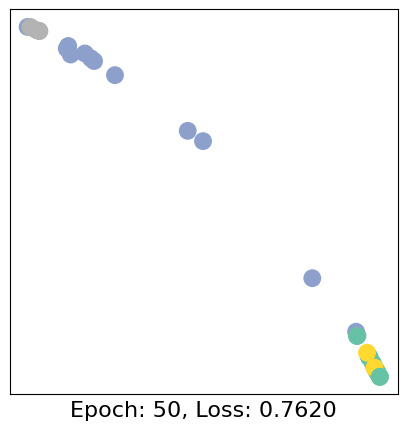

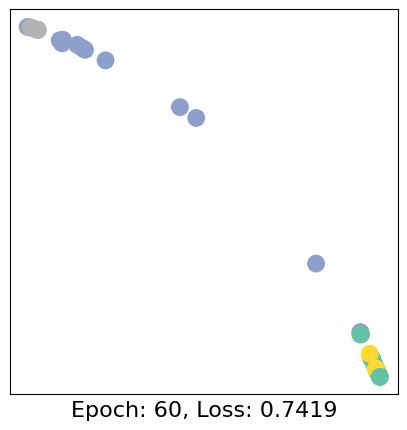

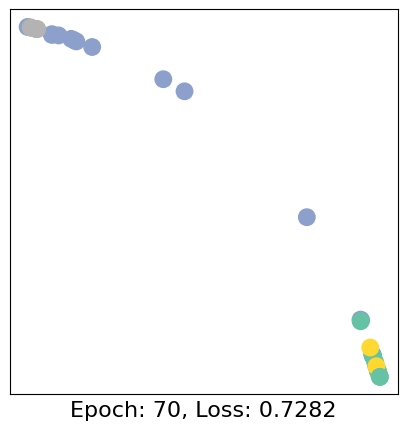

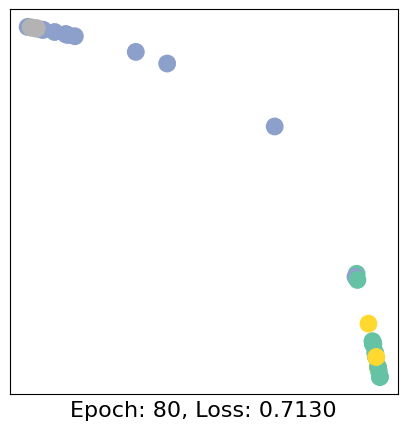

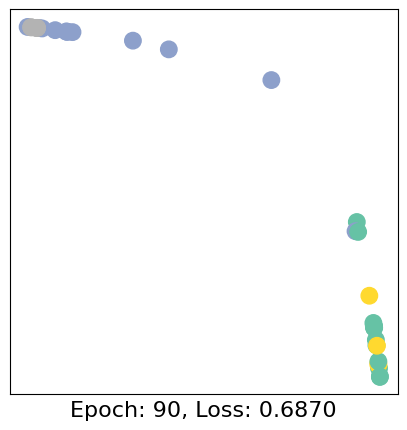

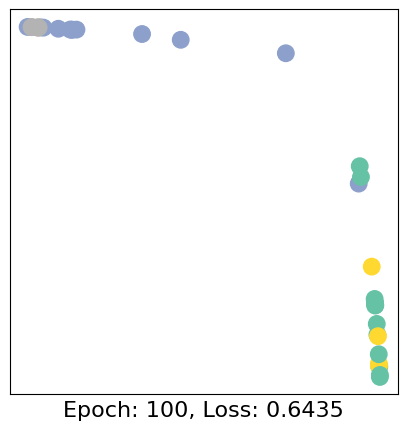

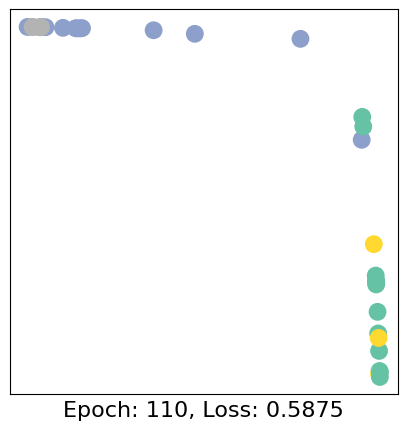

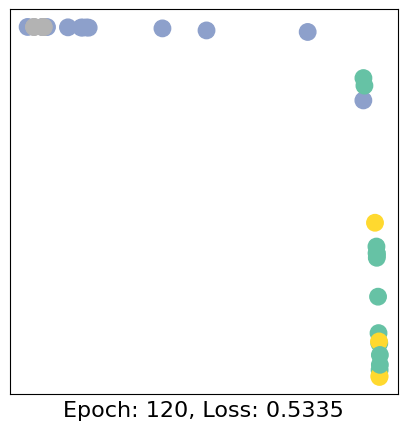

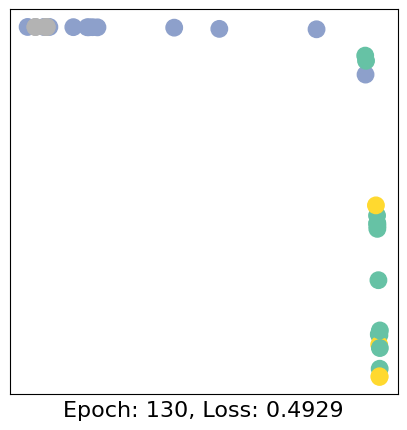

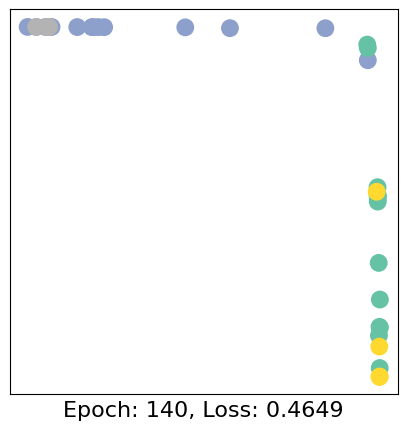

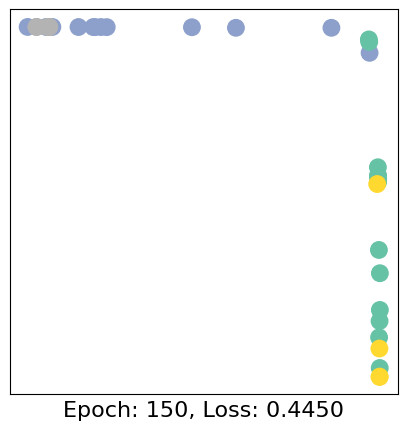

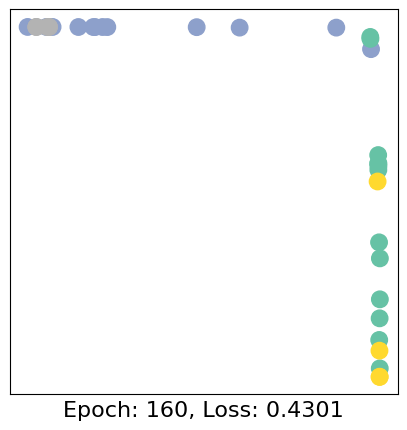

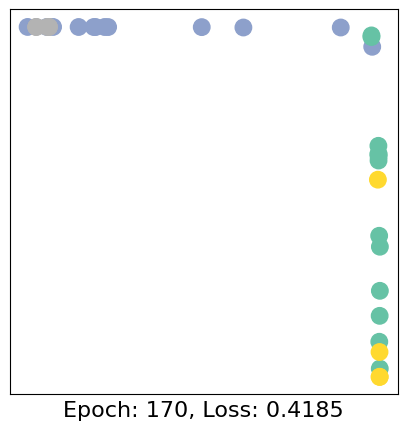

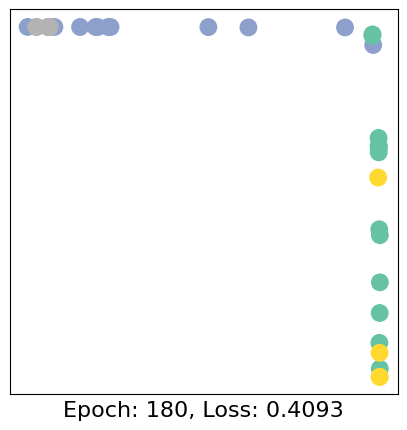

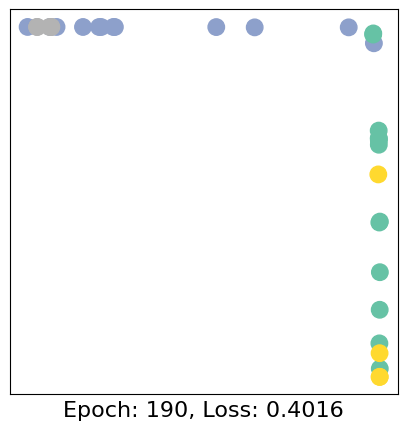

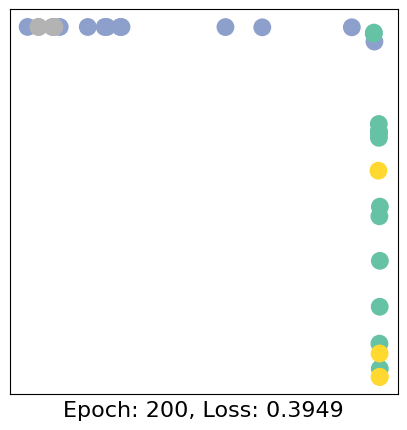

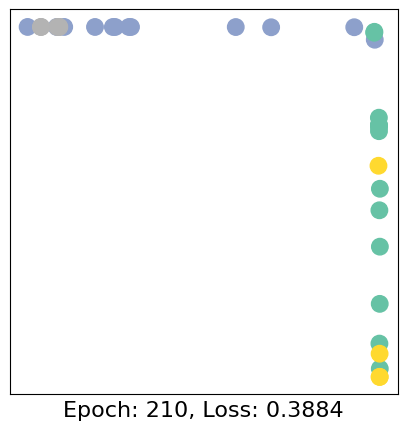

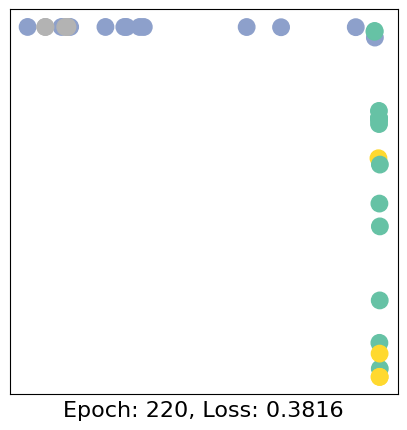

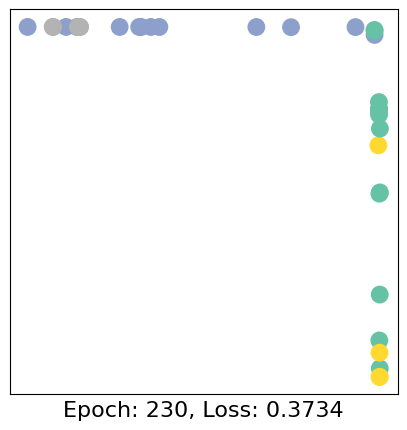

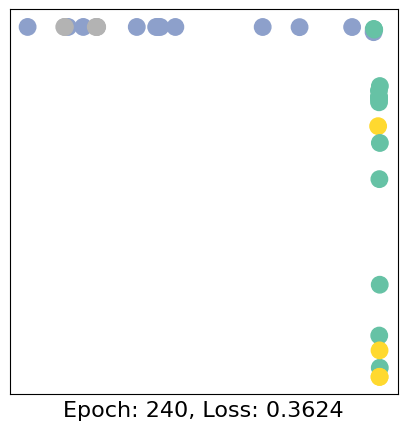

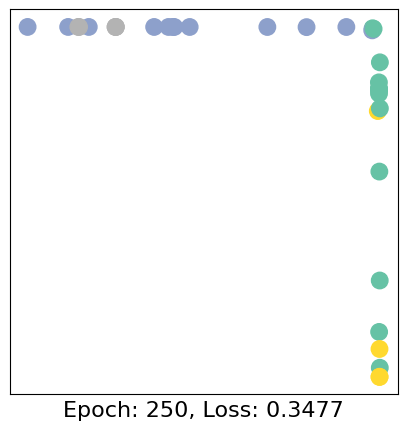

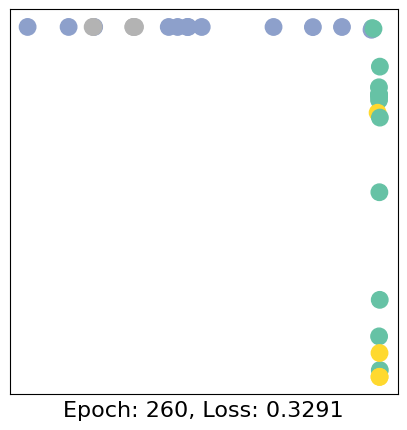

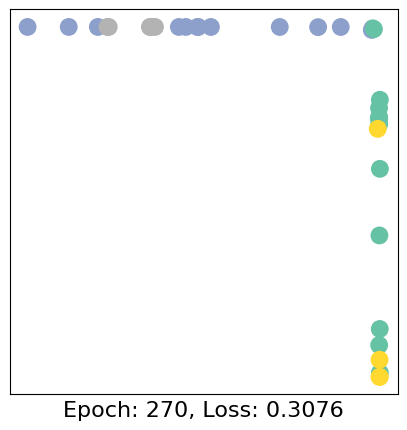

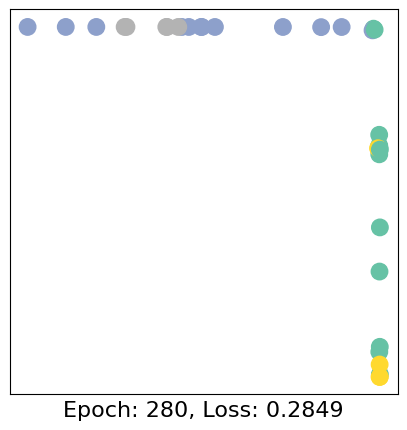

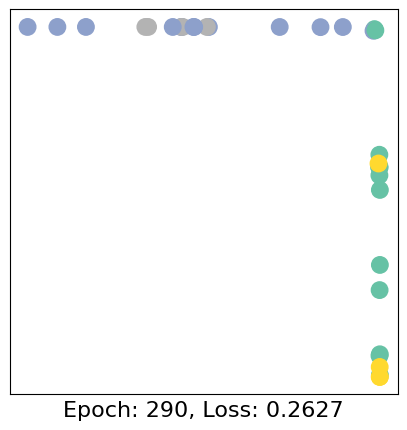

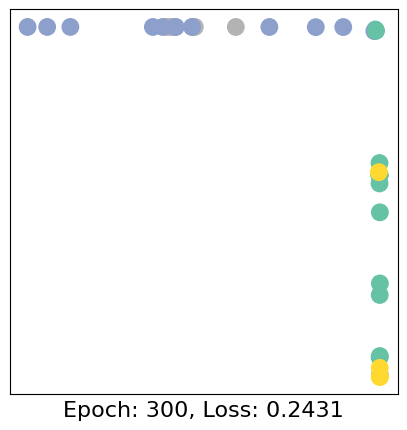

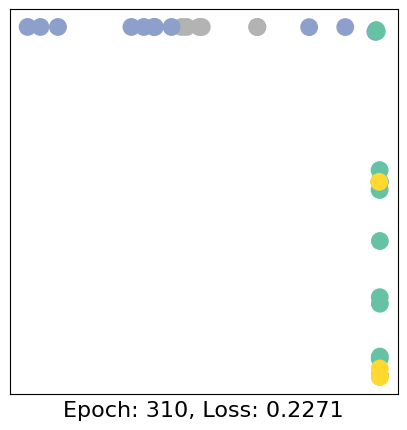

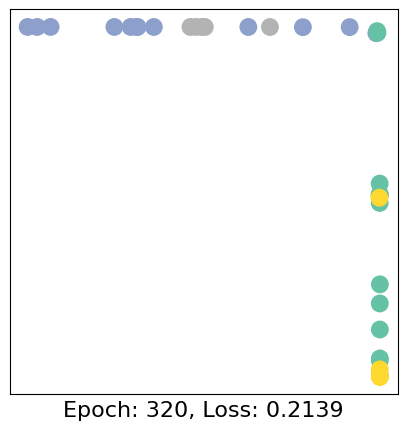

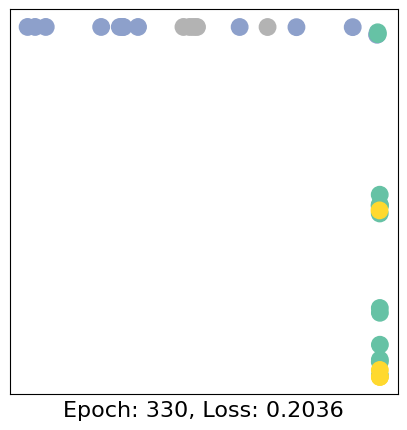

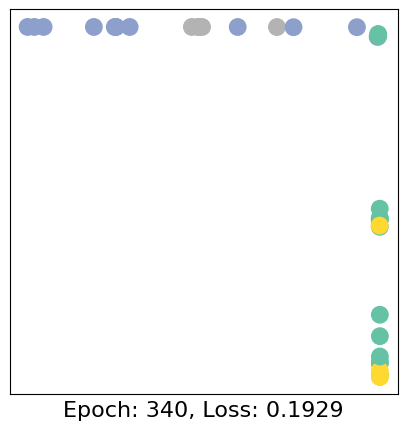

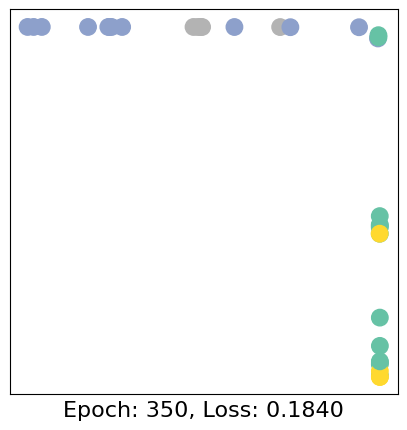

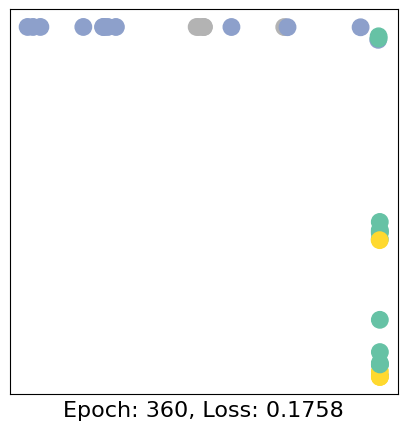

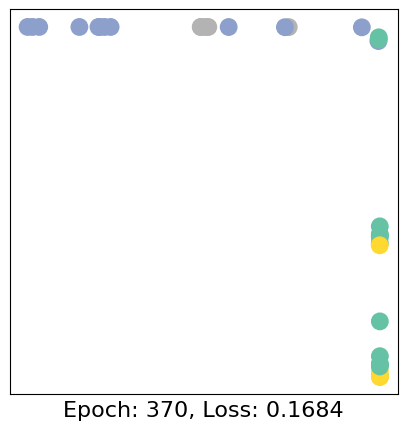

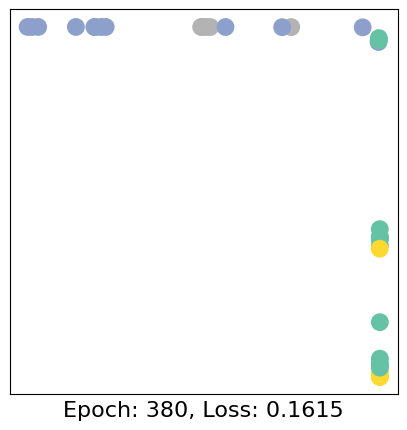

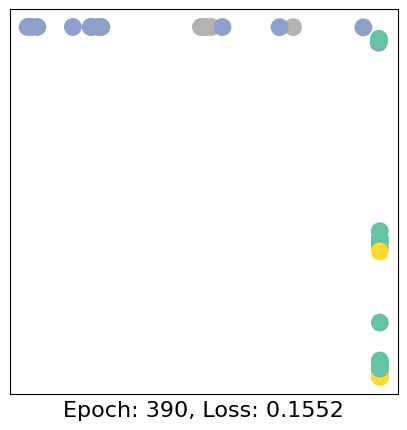

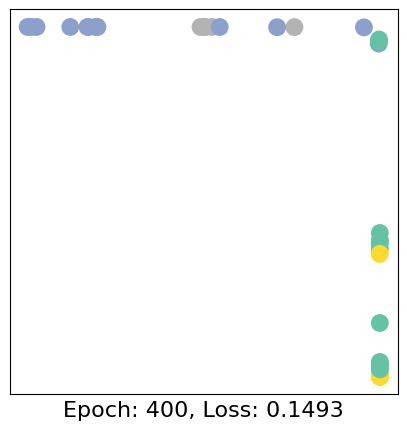

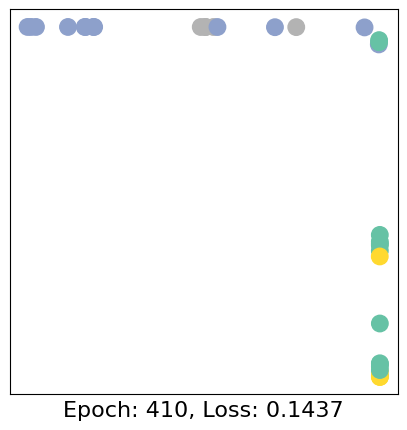

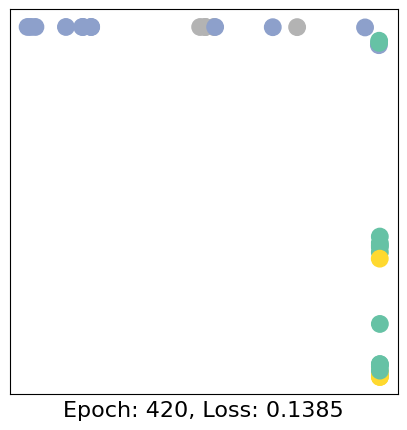

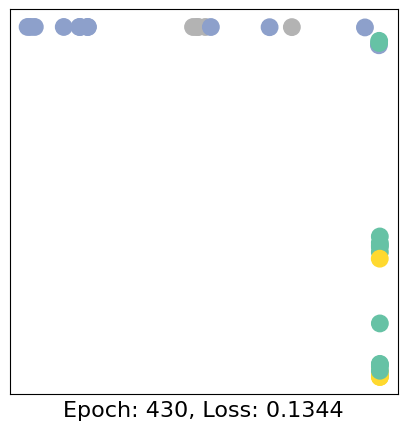

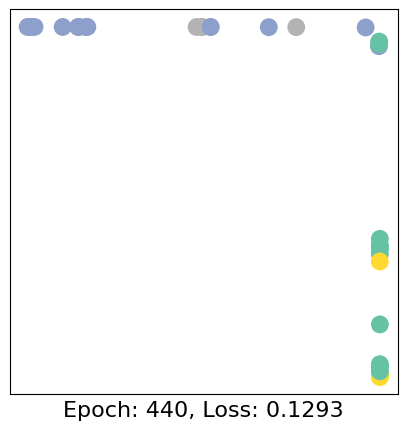

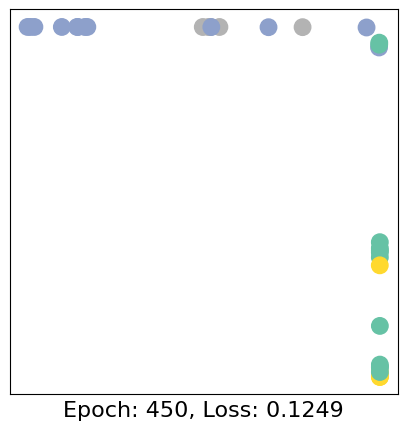

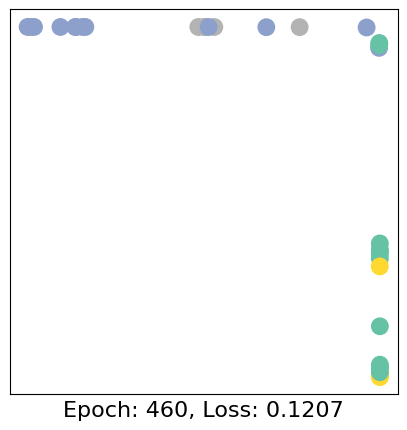

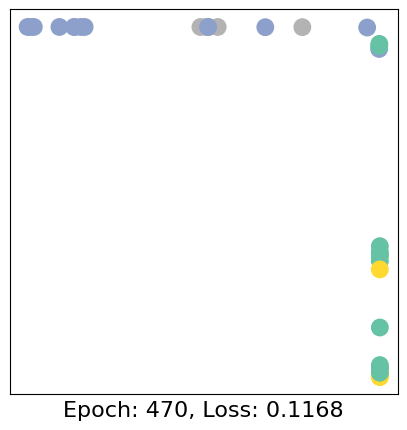

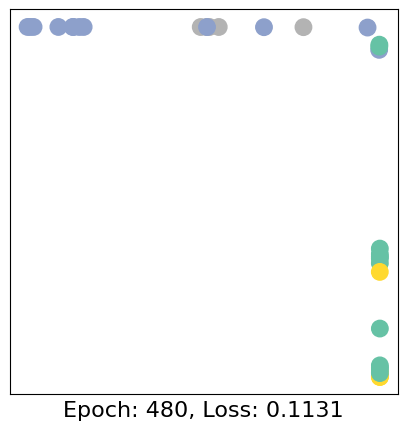

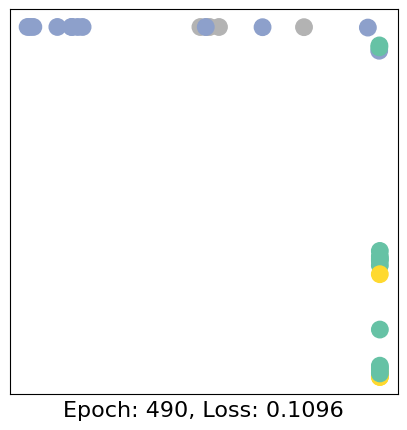

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion. # nn.L1Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

num_epochs = 500

for epoch in range(num_epochs):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

Como se puede ver, nuestro modelo GCN de 3 capas logra separar linealmente las comunidades y clasificar correctamente la mayoría de los nodos.

Además, hicimos todo esto con unas pocas líneas de código, gracias a la biblioteca Geométrica PyTorch que nos ayudó con el manejo de datos y las implementaciones de GNN.


## **Creando una nueva GCN**
Vamos a crear otra red que sea capaz de entrenar con las etiquetas de los nodos (labels).

## Cargando los módulos necesaios

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv

# Definiendo una nueva clase GCN

In [ ]:
class GCN_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_2, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
#@title ## Definir los parámetros del modelo
input_dim = dataset.num_features
hidden_dim = 16
output_dim = dataset.num_classes

print("El número de dimensiones inputs son : "+str(input_dim))
print("El número de dimensiones outputs son : "+str(output_dim))

El número de dimensiones inputs son : 34
El número de dimensiones outputs son : 4


In [ ]:
model = GCN_2(input_dim, hidden_dim, output_dim)
print(model)

GCN_2(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
)


## Crear un objeto DataLoader para cargar los datos en lotes

In [ ]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Vamos a entrenar considerando un nodo a la vez. Se extraerá información en base a las características del nodo como también a las interconecciones entre nodos.

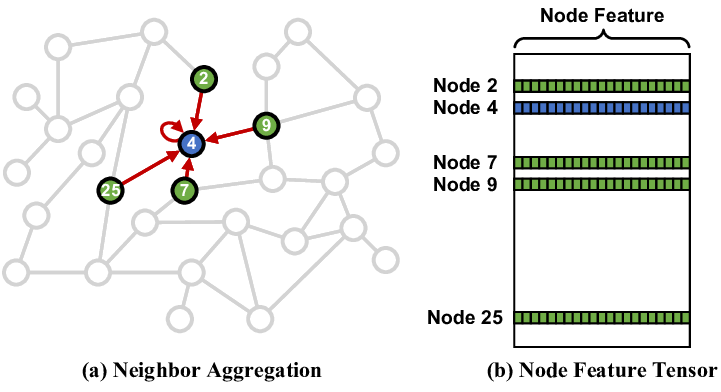

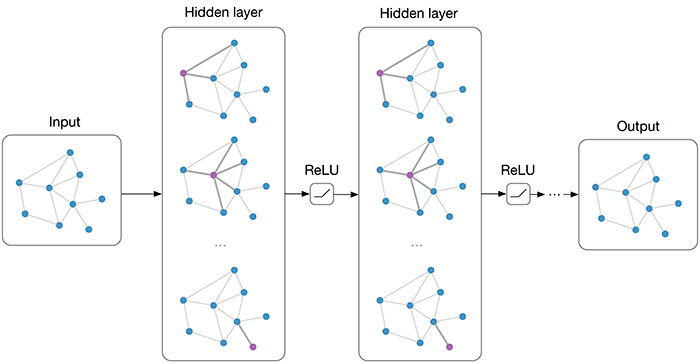

## Entrenando el modelo

In [ ]:
# Construir el modelo GCN
model2 = GCN_2(input_dim, hidden_dim, output_dim)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss() ##nn.NLLLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

num_epochs = 20

# Entrenamiento del modelo
model2.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model2(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f'Epoch: {epoch+1}, Loss: {avg_loss}')

Epoch: 1, Loss: 1.392221212387085
Epoch: 2, Loss: 1.3695961236953735
Epoch: 3, Loss: 1.3487461805343628
Epoch: 4, Loss: 1.329527735710144
Epoch: 5, Loss: 1.3106861114501953
Epoch: 6, Loss: 1.2915213108062744
Epoch: 7, Loss: 1.2718710899353027
Epoch: 8, Loss: 1.2518551349639893
Epoch: 9, Loss: 1.231553554534912
Epoch: 10, Loss: 1.210710883140564
Epoch: 11, Loss: 1.1893757581710815
Epoch: 12, Loss: 1.167551875114441
Epoch: 13, Loss: 1.1451665163040161
Epoch: 14, Loss: 1.1223773956298828
Epoch: 15, Loss: 1.0992454290390015
Epoch: 16, Loss: 1.0758354663848877
Epoch: 17, Loss: 1.0523422956466675
Epoch: 18, Loss: 1.0285245180130005
Epoch: 19, Loss: 1.0045945644378662
Epoch: 20, Loss: 0.9805212616920471


## Evaluando el modelo



In [ ]:
model2.eval()
correct = 0
total = 0

# Iterar sobre los lotes de datos
for batch in loader:
    # Realizar inferencia con el modelo
    out = model2(batch.x, batch.edge_index)

    # Obtener las predicciones del modelo
    _, predicted = torch.max(out, 1)

    # Actualizar los contadores
    total += batch.y.size(0)
    correct += (predicted == batch.y).sum().item()

    # Imprimir las predicciones y los valores reales de cada nodo
    for i in range(len(predicted)):
        print(f"Nodo {i}: Predicción = {predicted[i]}, Valor real = {batch.y[i]}")

# Calcular la precisión
accuracy = correct / total

# Imprimir la precisión del modelo en el conjunto de datos de prueba
print(f'Test Accuracy: {accuracy:.4f}')

Nodo 0: Predicción = 1, Valor real = 1
Nodo 1: Predicción = 1, Valor real = 1
Nodo 2: Predicción = 1, Valor real = 1
Nodo 3: Predicción = 1, Valor real = 1
Nodo 4: Predicción = 1, Valor real = 3
Nodo 5: Predicción = 1, Valor real = 3
Nodo 6: Predicción = 1, Valor real = 3
Nodo 7: Predicción = 1, Valor real = 1
Nodo 8: Predicción = 0, Valor real = 0
Nodo 9: Predicción = 0, Valor real = 1
Nodo 10: Predicción = 1, Valor real = 3
Nodo 11: Predicción = 1, Valor real = 1
Nodo 12: Predicción = 1, Valor real = 1
Nodo 13: Predicción = 1, Valor real = 1
Nodo 14: Predicción = 0, Valor real = 0
Nodo 15: Predicción = 0, Valor real = 0
Nodo 16: Predicción = 0, Valor real = 3
Nodo 17: Predicción = 1, Valor real = 1
Nodo 18: Predicción = 0, Valor real = 0
Nodo 19: Predicción = 1, Valor real = 1
Nodo 20: Predicción = 0, Valor real = 0
Nodo 21: Predicción = 1, Valor real = 1
Nodo 22: Predicción = 0, Valor real = 0
Nodo 23: Predicción = 0, Valor real = 0
Nodo 24: Predicción = 0, Valor real = 2
Nodo 25: P

## **Tarea**
* Probar diferentes números de epocas en ambos casos. ¿Mejoran los resultados?
* En la primer red comentar la siguiente linea :
> torch.manual_seed(1234) (debe quedar asi (#torch.manual_seed(1234))

¿Cambián los resultados? ¿Por qué?

* Modificar el criterion y el optimizador. Observa si hay cambios

## **Modificando la estructura de la red**
* Agregar una capa más de GCNConv. ¿Mejoran los resultados con la misma cantidad de epocas?

In [ ]:
class GCN_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_2, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim2) # capa nueva
        self.conv3 = GCNConv(hidden_dim2, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
#@title ## Definir los parámetros del modelo
input_dim = dataset.num_features
hidden_dim = 16
hidden_dim2 = 8
output_dim = dataset.num_classes

print("El número de dimensiones inputs son : "+str(input_dim))
print("El número de dimensiones outputs son : "+str(output_dim))

El número de dimensiones inputs son : 34
El número de dimensiones outputs son : 4


In [ ]:
model3 = GCN_2(input_dim, hidden_dim, output_dim)
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [ ]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# Construir el modelo GCN
model3 = GCN_2(input_dim, hidden_dim, output_dim)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss() ##nn.NLLLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

num_epochs = 20

# Entrenamiento del modelo
model3.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model3(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f'Epoch: {epoch+1}, Loss: {avg_loss}')

Epoch: 1, Loss: 1.3848285675048828
Epoch: 2, Loss: 1.3686552047729492
Epoch: 3, Loss: 1.3533486127853394
Epoch: 4, Loss: 1.3369261026382446
Epoch: 5, Loss: 1.3181606531143188
Epoch: 6, Loss: 1.297999620437622
Epoch: 7, Loss: 1.2770222425460815
Epoch: 8, Loss: 1.2555738687515259
Epoch: 9, Loss: 1.2336128950119019
Epoch: 10, Loss: 1.2114163637161255
Epoch: 11, Loss: 1.1890935897827148
Epoch: 12, Loss: 1.1669721603393555
Epoch: 13, Loss: 1.1448652744293213
Epoch: 14, Loss: 1.1224511861801147
Epoch: 15, Loss: 1.0996637344360352
Epoch: 16, Loss: 1.076554298400879
Epoch: 17, Loss: 1.0528620481491089
Epoch: 18, Loss: 1.0284754037857056
Epoch: 19, Loss: 1.0031702518463135
Epoch: 20, Loss: 0.9772005677223206


In [ ]:
model3.eval()
correct = 0
total = 0

# Iterar sobre los lotes de datos
for batch in loader:
    # Realizar inferencia con el modelo
    out = model3(batch.x, batch.edge_index)

    # Obtener las predicciones del modelo
    _, predicted = torch.max(out, 1)

    # Actualizar los contadores
    total += batch.y.size(0)
    correct += (predicted == batch.y).sum().item()

    # Imprimir las predicciones y los valores reales de cada nodo
    for i in range(len(predicted)):
        print(f"Nodo {i}: Predicción = {predicted[i]}, Valor real = {batch.y[i]}")

# Calcular la precisión
accuracy = correct / total

# Imprimir la precisión del modelo en el conjunto de datos de prueba
print(f'Test Accuracy: {accuracy:.4f}')

Nodo 0: Predicción = 1, Valor real = 1
Nodo 1: Predicción = 1, Valor real = 1
Nodo 2: Predicción = 1, Valor real = 1
Nodo 3: Predicción = 1, Valor real = 1
Nodo 4: Predicción = 1, Valor real = 3
Nodo 5: Predicción = 1, Valor real = 3
Nodo 6: Predicción = 1, Valor real = 3
Nodo 7: Predicción = 1, Valor real = 1
Nodo 8: Predicción = 1, Valor real = 0
Nodo 9: Predicción = 1, Valor real = 1
Nodo 10: Predicción = 1, Valor real = 3
Nodo 11: Predicción = 1, Valor real = 1
Nodo 12: Predicción = 1, Valor real = 1
Nodo 13: Predicción = 1, Valor real = 1
Nodo 14: Predicción = 0, Valor real = 0
Nodo 15: Predicción = 0, Valor real = 0
Nodo 16: Predicción = 1, Valor real = 3
Nodo 17: Predicción = 1, Valor real = 1
Nodo 18: Predicción = 0, Valor real = 0
Nodo 19: Predicción = 1, Valor real = 1
Nodo 20: Predicción = 0, Valor real = 0
Nodo 21: Predicción = 1, Valor real = 1
Nodo 22: Predicción = 0, Valor real = 0
Nodo 23: Predicción = 0, Valor real = 0
Nodo 24: Predicción = 0, Valor real = 2
Nodo 25: P